In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

np.random.seed(0)

In [3]:
sampled = np.load('sampled_2D_wider.npy')

In [4]:
sampled = np.array(sampled, dtype=np.float32)

In [5]:
data = sampled[1000:2000]

In [94]:
k = 4
d = 2

In [177]:
def run_one_gibbs(data, cluster_allocs, uniq_vals, weights):

    n_clus = len(weights)
    
    for h in range(n_clus):
        clusdata = data[cluster_allocs == h]
        if len(clusdata) == 0:
            uniq_vals[h, :] = sample_uniq_vals_prior()
        else:
            uniq_vals[h, :] = sample_uniq_vals_fullcond(clusdata)
    
    weights = update_weights(cluster_allocs, n_clus, k)
    
    cluster_allocs = update_cluster_allocs(data, weights, uniq_vals)
    
    return cluster_allocs, uniq_vals, weights

def run_mcmc(data, k, niter=1500, nburn=500, thin=5):    #niter=7500, nburn=2500,
    cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
    weights = np.ones(k) / k
    
    # 4  bivariate normal e 4 matrices 2x2
    uniq_vals = np.dstack([
        [[-7, -1.35062042],
       [ 0.04850157,  7],
       [ 0, -0.37953119],
       [ 0, 5]],
        tfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.diag(np.ones(d))) ).sample(k)])
    
    allocs_out = []
    uniq_vals_out = []
    weights_out = []
    
    for i in range(niter):
        cluster_allocs, uniq_vals, weights = run_one_gibbs(
            data, cluster_allocs, uniq_vals, weights)
        
        if i > nburn and i % thin == 0:
            allocs_out.append(cluster_allocs)
            uniq_vals_out.append(uniq_vals.copy())
            weights_out.append(weights)
            
        if i % 10 == 0:
            print("\rIter {0} / {1}".format(i+1, niter), flush=False, end=" ")
            
    return allocs_out, uniq_vals_out, weights_out

In [175]:

def update_cluster_allocs(data, weights, uniq_vals):
    
    #logprobs = tfd.Normal(uniq_vals[:, 0], np.sqrt(uniq_vals[:, 1:2])).log_prob(data[:, np.newaxis])
    logprobs = tfd.MultivariateNormalFullCovariance(uniq_vals[:,:,0], uniq_vals[:,:,1:3]).log_prob(data[:, np.newaxis])
    logprobs += np.log(weights)
    probs =  np.exp(logprobs)/np.sum(np.exp(logprobs), axis=1)[:,None]
    #for i in range(len(probs)):
    #    if np.all(probs[i] == 0):
    #        probs[i] = np.ones(k) / k
    #print(probs)
    return tfd.Categorical(probs=probs, validate_args=True).sample()


def update_weights(cluster_allocs, n_clus, k):

    n_by_clus = np.array([np.sum(cluster_allocs == h) for h in range(n_clus)])
    post_params = np.ones(k) * 10 + n_by_clus
    #print(post_params)
    return tfd.Dirichlet(post_params.astype(float)).sample()


def sample_uniq_vals_prior():
    
    chol = tf.linalg.cholesky(np.diag(np.ones(d))) 
    prec = tfd.WishartTriL(df=d, scale_tril=chol).sample()
    var = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis = 0), var).sample()
    return np.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]])
    

def sample_uniq_vals_fullcond(clusdata):
    
    n=len(clusdata)
    W = tf.linalg.inv(np.diag(np.ones(d))+(n-1)*np.cov(clusdata, rowvar = False)+(n/1+n)*np.dot(np.mean(clusdata, axis = 0)-np.mean(data, axis = 0),np.mean(clusdata, axis = 0)-np.mean(data, axis = 0)))
    chol = tf.linalg.cholesky(W) 
    prec = tfd.WishartTriL(df=d+n, scale_tril=chol).sample()
    var = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance((np.mean(np.array(data), axis = 0)+n*np.mean(clusdata, axis = 0))/(1+n), var/(1+n)).sample()
    return np.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]])


In [178]:
allocs_out, uniq_vals_out, weights_out = run_mcmc(data, k)

Iter 361 / 1500 

/Users/Manuel/.virtualenvs/Bayes_Exe/lib/python3.8/site-packages/tensorflow_probability/python/internal/backend/numpy/numpy_math.py:663: RuntimeWarning: divide by zero encountered in log
  lambda x, name=None: np.log(_convert_to_tensor(x)))


Iter 1491 / 1500 

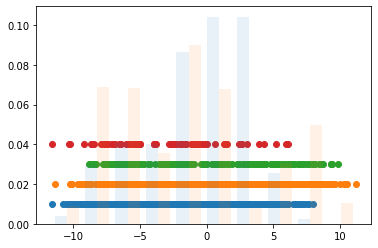

In [179]:
plt.hist(data, density=True, alpha=0.1)
for h in range(k):
    currd = data[allocs_out[-4] == h]
    plt.scatter(currd, np.zeros_like(currd) + 0.01 * (h+1))

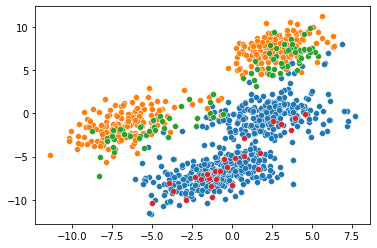

In [182]:
# usando pochi samples
for h in range(k):
    currd = data[allocs_out[-1] == h]
    sns.scatterplot(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd],)

In [183]:
M = [[np.mean(data[allocs_out[-1] == h][:,0]), np.mean(data[allocs_out[-1] == h][:,1])] for h in range(k)]

In [184]:
M

[[0.4013975, -3.8826659],
 [-2.016194, 3.0115418],
 [-0.58100045, 2.6257038],
 [-0.32554406, -6.020005]]

In [173]:
tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.linalg.inv(np.diag(0.07*np.ones(d)))).sample(k)

array([[-2.77237663, -1.35062042],
       [ 0.04850157,  0.50004505],
       [ 1.64900429, -0.37953119],
       [ 4.38290637,  0.52275197]])

In [135]:
import arviz as az

In [166]:
means = [val[:,:,0] for val in uniq_vals_out]

In [185]:
first_comp = [mean[0,:] for mean in means]

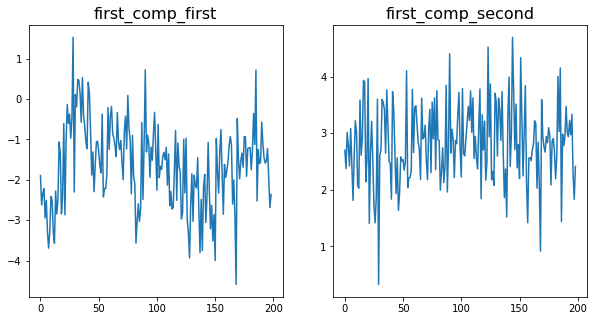

In [186]:
first_comp = [mean[0,:] for mean in means]
first_comp_first = [first_comp_mean[0] for first_comp_mean in first_comp]
first_comp_second = [first_comp_mean[1] for first_comp_mean in first_comp]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(np.arange(len(first_comp_first)), first_comp_first)
axes[0].set_title("first_comp_first", fontsize=16)

axes[1].plot(np.arange(len(first_comp_second)), first_comp_second,)
axes[1].set_title("first_comp_second", fontsize=16)

plt.show()

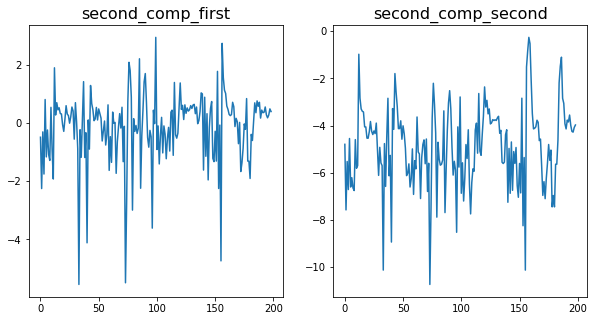

In [190]:
second_comp = [mean[1,:] for mean in means]
second_comp_first = [second_comp_mean[0] for second_comp_mean in second_comp]
second_comp_second = [second_comp_mean[1] for second_comp_mean in second_comp]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(np.arange(len(second_comp_first)), second_comp_first)
axes[0].set_title("second_comp_first", fontsize=16)

axes[1].plot(np.arange(len(second_comp_second)), second_comp_second,)
axes[1].set_title("second_comp_second", fontsize=16)

plt.show()

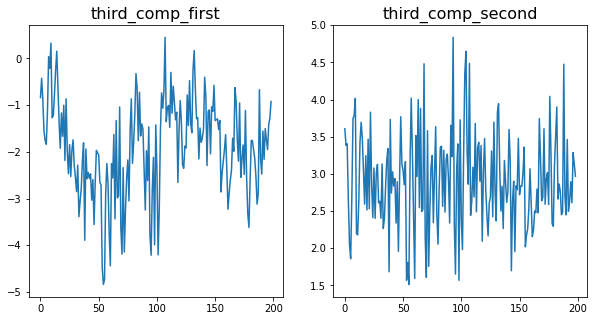

In [191]:
third_comp = [mean[2,:] for mean in means]
third_comp_first = [third_comp_mean[0] for third_comp_mean in third_comp]
third_comp_second = [third_comp_mean[1] for third_comp_mean in third_comp]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(np.arange(len(third_comp_first)), third_comp_first)
axes[0].set_title("third_comp_first", fontsize=16)

axes[1].plot(np.arange(len(third_comp_second)), third_comp_second,)
axes[1].set_title("third_comp_second", fontsize=16)

plt.show()

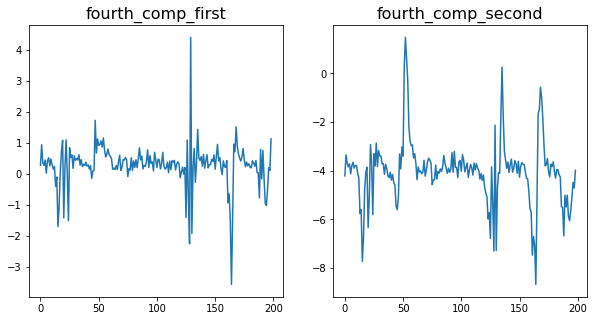

In [193]:
fourth_comp = [mean[3,:] for mean in means]
fourth_comp_first = [fourth_comp_mean[0] for fourth_comp_mean in fourth_comp]
fourth_comp_second = [fourth_comp_mean[1] for fourth_comp_mean in fourth_comp]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(np.arange(len(fourth_comp_first)), fourth_comp_first)
axes[0].set_title("fourth_comp_first", fontsize=16)

axes[1].plot(np.arange(len(fourth_comp_second)), fourth_comp_second,)
axes[1].set_title("fourth_comp_second", fontsize=16)

plt.show()

In [ ]:
logprobs = tfd.MultivariateNormalFullCovariance(uniq_vals[:,:,0], uniq_vals[:,:,1:3]).log_prob(data[:, np.newaxis])
    logprobs += np.log(weights)
    probs =  np.exp(logprobs)/np.sum(np.exp(logprobs), axis=1)[:,None]

In [155]:
[weight[0] for weight in weights_out]

[0.32115219420817354,
 0.23940796516223686,
 0.24063737784608558,
 0.28759475529641876,
 0.27717919663347784,
 0.26025655131773695,
 0.27266690968518736,
 0.2772080123962568,
 0.2955147520833076,
 0.2849526549544556,
 0.23191001100240705,
 0.22535243908563113,
 0.19678366852790555,
 0.1237170057749448,
 0.14385261952346204,
 0.20004959956441146,
 0.19632327187563678,
 0.26434456058034794,
 0.19805805272074922,
 0.25094794560615974,
 0.23360747836172646,
 0.24806805516303782,
 0.21352834425824258,
 0.24006183694346958,
 0.21011547276691775,
 0.21082407343270868,
 0.21413760759222347,
 0.20159095264753496,
 0.17728099721489868,
 0.18087645389407794,
 0.17455737457090675,
 0.19108551393710932,
 0.16739191636126396,
 0.21769156593762523,
 0.16846906011703836,
 0.2577904314525641,
 0.20967775923899817,
 0.17742233580310565,
 0.1710630888911479,
 0.15479440511802428,
 0.15987168585480147,
 0.24389415961492206,
 0.2685419061624641,
 0.24722026590155013,
 0.19207667313454946,
 0.19970816822234

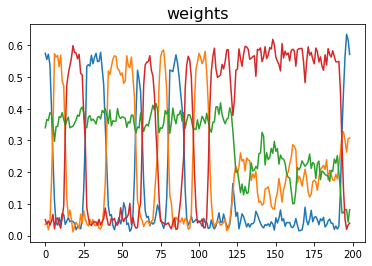

In [194]:
first_weight = [weight[0] for weight in weights_out]
second_weight = [weight[1] for weight in weights_out]
third_weight = [weight[2] for weight in weights_out]
fourth_weight = [weight[3] for weight in weights_out]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.arange(len(first_weight)), first_weight)
ax.plot(np.arange(len(second_weight)), second_weight)
ax.plot(np.arange(len(third_weight)), third_weight)
ax.plot(np.arange(len(fourth_weight)), fourth_weight)
ax.set_title("weights", fontsize=16)


plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(np.arange(len(uniq_vals_out)), means)
axes[0].plot(np.arange(len(uniq_vals_out)), means)
axes[0].plot(np.arange(len(uniq_vals_out)), means)
axes[0].plot(np.arange(len(uniq_vals_out)), means)
axes[0].set_title("Means", fontsize=16)

axes[1].vlines(np.arange(len(uniq_vals_out)), chains[:, 1] - 0.3, chains[:, 1] + 0.3)
axes[1].set_title("n", fontsize=16)

plt.show()

In [ ]:
chains_az = az.convert_to_inference_data(
    {"theta": chains[:, 0], "n": chains[:, 1]})

print(az.ess(chains_az))